# EDA

# 1st step: let's see how many unique features do we have, their field types and also dataset size

In [2]:
import json
import os
from pathlib import Path

dataset = Path('/Users/layvvs/Desktop/HSE/Studying/year-project/downloaded_tracks')

meta_data = dataset/'metadata'
audio_data = dataset/'audio'

## Dataset size

In [3]:
meta_data_content = os.listdir(meta_data)
audio_data_content = os.listdir(audio_data)

meta_data_size = len(meta_data_content)
audio_data_size = len(audio_data_content)

print('Meta data size:', meta_data_size)
print('Audio data size:', audio_data_size)

Meta data size: 2001
Audio data size: 2001


## Fields and their types

In [4]:
from collections import Counter
import pandas as pd

fields_count = Counter()


def parse_field(field, content):
    if not isinstance(content, dict):
        return [(field, type(content).__name__)]
    result = []
    for subfield, subcontent in content.items():
        result.extend(parse_field(subfield, subcontent))
    return result


for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        fields = []
        for field, content in data.items():
            fields.extend(parse_field(field, content))
        fields_count.update(fields)


dataset_info = pd.DataFrame(
    [
        (field[0], field[1], field_count)
        for field, field_count in fields_count.items()
    ],
    columns=['field', 'type', 'count']
)
dataset_info

,field,type,count
0,id,str,2001
1,name,str,2001
2,duration,int,2001
3,artist_id,str,2001
4,artist_name,str,2001
5,album_id,str,2001
6,album_name,str,2001
7,releasedate,str,2001
8,waveform,str,2001
9,vocalinstrumental,str,2001


### Intermediate conclusions
At this point we've `23` unique features (we'll take `avgnote` as `float`).

Now we've to decide how add audio, waveform and list to dataframe.

I think i'll create another file for the peaks values and add the file path to the table for the audio as well.

For the categorical features (list, str) we can use type casting (many string types in data originally are int or float), encodings and text embeddings.

# 2nd step: data preprocessing. Type casting, encoding and embeddings 

## Let's look at the unique values of categorical data

Field artist_id, unique values 669
Field album_id, unique values 1065
Field vocalinstrumental, unique values 3
Field lang, unique values 9
Field gender, unique values 4
Field acousticelectric, unique values 3
Field speed, unique values 6
Field genres, unique values 140
Field instruments, unique values 61
Field vartags, unique values 463


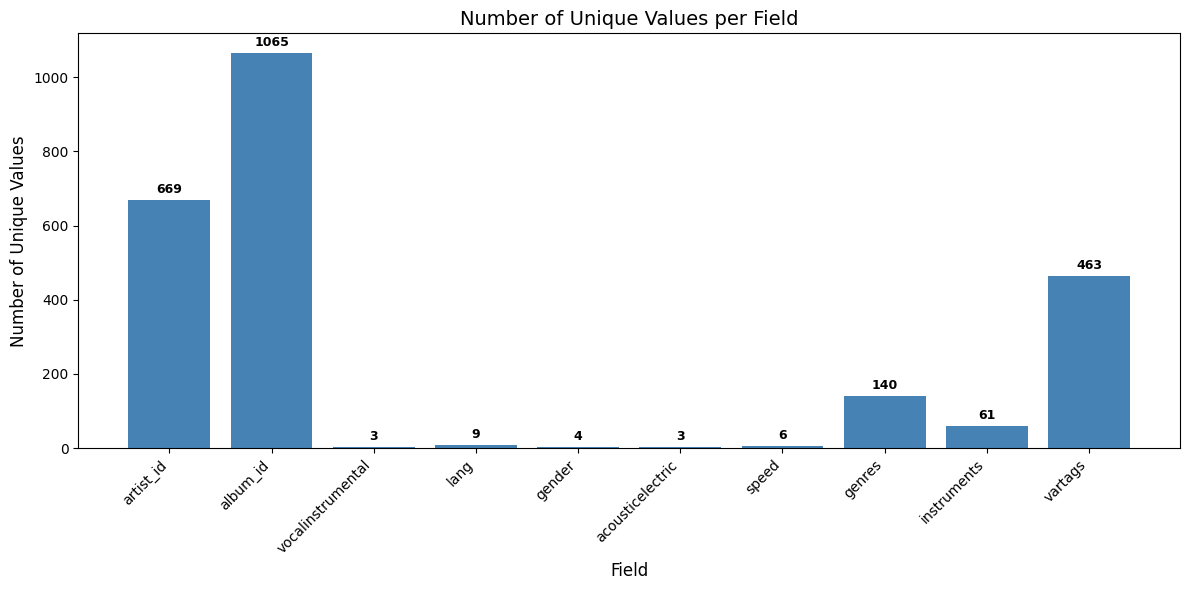

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

skip_fileds = ['id', 'artist_name', 'album_name', 'releasedate', 'waveform', 'name']

unique_values = defaultdict(set)

def parse_field(field, content):
    if isinstance(content, float) or isinstance(content, int) or field in skip_fileds:
        return
    if isinstance(content, list):
        unique_values[field].update(content)
        return
    if isinstance(content, str):
        unique_values[field].update([content])
        return
    for subfield, subcontent in content.items():
        parse_field(subfield, subcontent)

for meta_data_file in meta_data_content:
    with open(meta_data/meta_data_file) as f:
        data: dict = json.load(f)
        for field, content in data.items():
            parse_field(field, content)

field_counts = {field: len(values) for field, values in unique_values.items()}

for field, content in field_counts.items():
    print(f'Field {field}, unique values {content}')

fields, counts = zip(*field_counts.items())

plt.figure(figsize=(12, 6))
bars = plt.bar(fields, counts, color='steelblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Number of Unique Values per Field', fontsize=14)
plt.xlabel('Field', fontsize=12)
plt.ylabel('Number of Unique Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Intermediate conclusions
* We can see that we've `669` *unique artists*, `1065` *unique albums* and `2001` *songs* in current dataset.

* We can use different techniques of encoding for fields `vocalinstrumental`, `lang`, `gender`, `acousticelectric`, `speed` because of small amount of unique values.

* We can split field `releasedate` on year/mont/day columns.

* I think we should use an embedding model for fields `genres`, `instuments`, `vartags`.

We can also drop fields like song/artist/album name, id-fields for model training, but rn i'm not sure about this. We'll see